In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
import subprocess
from Bio import SeqIO

In [15]:
# Example energy function using simple placeholder
def calculate_energy(sequence, angles):
    # Placeholder for energy calculation
    return sum([np.sin(angle)**2 for angle in angles])

In [24]:
import math

def save_structure_to_pdb(sequences, angles, filename="output.pdb"):
    x, y, z = 0.0, 0.0, 0.0  # Starting coordinates
    chains = list(sequences.keys())  # Get chain IDs (e.g., A, B, C, D)
    with open(filename, "w") as f:
        f.write(f"MODEL\n")
        atom_index = 1
        angle_index = 0

        for chain_id, sequence in sequences.items():
            for i, residue in enumerate(sequence):
                if angle_index >= len(angles):  # Avoid index errors
                    break

                # Calculate new coordinates based on angles (simple 3D spread)
                angle = angles[angle_index]
                x += math.cos(math.radians(angle))
                y += math.sin(math.radians(angle))
                z += angle / 100.0  # Spread in Z based on angle
                
                # Write atom record for this residue
                f.write(
                    f"ATOM  {atom_index:5d}  CA  {residue:3s} {chain_id}   {i+1:3d}      {x:8.3f} {y:8.3f} {z:8.3f}  1.00  0.00           C\n"
                )
                atom_index += 1
                angle_index += 1  # Move to the next angle

        f.write("ENDMDL\n")
    print(f"Structure saved to {filename}")


In [17]:
# Visualize structure with PyMOL
def visualize_with_pymol(filename="output.pdb"):
    try:
        subprocess.run(["pymol", filename])
    except FileNotFoundError:
        print("PyMOL is not installed or not found in your PATH.")

In [18]:
# Initialize population (Step 3)
def initialize_population(size, sequence_length):
    return [np.random.uniform(-180, 180, sequence_length) for _ in range(size)]

In [19]:
# Evaluate fitness (Step 2)
def evaluate_population(population, sequence):
    return [calculate_energy(sequence, individual) for individual in population]

In [20]:
# Selection (Step 4: Tournament Selection)
def tournament_selection(population, fitness, k=3):
    selected = []
    for _ in range(len(population)):
        # Randomly choose k individuals and pick the best
        indices = random.sample(range(len(population)), k)
        selected.append(min(indices, key=lambda i: fitness[i]))
    return [population[i] for i in selected]

In [21]:
# Crossover (Step 5: Single-point crossover)
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

In [22]:
# Mutation (Step 6: Small random changes)
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] += np.random.uniform(-10, 10)
            individual[i] = np.clip(individual[i], -180, 180)  # Keep angles within valid range
    return individual

In [23]:
# Visualization of energy over generations
def plot_progress(progress):
    plt.figure(figsize=(10, 6))
    plt.plot(progress, marker='o')
    plt.title('Best Energy Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Energy')
    plt.grid()
    plt.show()

In [12]:
# Load multiple chains from a FASTA file
def load_chains_from_fasta(file_path):
    chains = {}
    with open(file_path, "r") as f:
        for record in SeqIO.parse(f, "fasta"):
            chain_ids = record.description.split("|")[1].strip()  # Extract chain info (e.g., "Chains A, C")
            sequence = str(record.seq)
            if "A" in chain_ids:
                chains["A"] = sequence
            if "B" in chain_ids:
                chains["B"] = sequence
            if "C" in chain_ids:
                chains["C"] = sequence
            if "D" in chain_ids:
                chains["D"] = sequence
    return chains

Loaded sequences for chains: ['A', 'C', 'B', 'D']
Generation 1: Best Energy = 265.8919340903224
Generation 2: Best Energy = 260.2299280233121
Generation 3: Best Energy = 256.45194977298706
Generation 4: Best Energy = 252.57875058230314
Generation 5: Best Energy = 252.50396207227064
Generation 6: Best Energy = 250.5093251407824
Generation 7: Best Energy = 249.22292725046427
Generation 8: Best Energy = 247.77526865183694
Generation 9: Best Energy = 250.9574222194031
Generation 10: Best Energy = 246.50629062010503
Generation 11: Best Energy = 243.80552747371618
Generation 12: Best Energy = 241.19416028259172
Generation 13: Best Energy = 241.88748231750031
Generation 14: Best Energy = 241.58944379227455
Generation 15: Best Energy = 243.3402462815376
Generation 16: Best Energy = 241.1303640882236
Generation 17: Best Energy = 239.75218331201813
Generation 18: Best Energy = 240.2699647567185
Generation 19: Best Energy = 238.52673505025757
Generation 20: Best Energy = 234.70768543550017
Genera

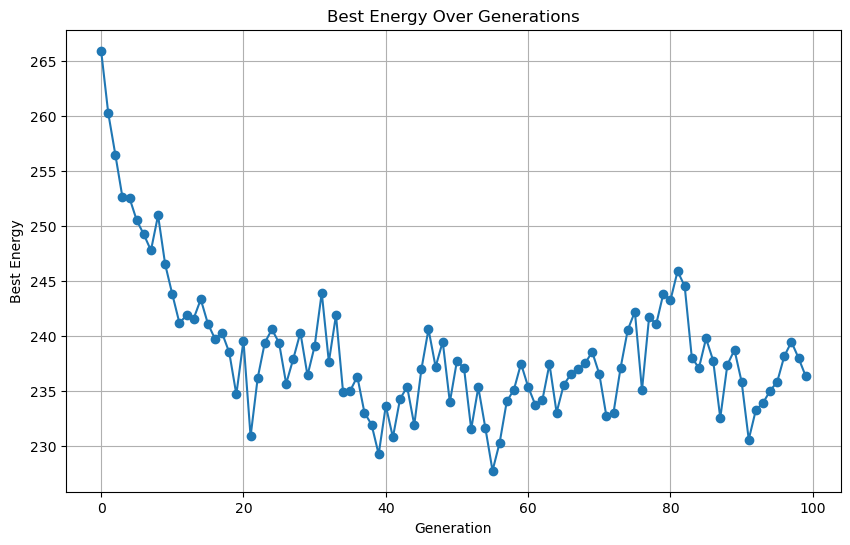

In [25]:
if __name__ == "__main__":
    # Parameters
    population_size = 20
    generations = 100
    mutation_rate = 0.1

    # Load real protein sequences from FASTA
    fasta_file = "Hemoglobin.fasta"  # Replace with actual FASTA file path
    sequences = load_chains_from_fasta(fasta_file)
    print(f"Loaded sequences for chains: {list(sequences.keys())}")

    # Combine all sequences into one for GA (this is used for optimization)
    combined_sequence = "".join(sequences.values())

    # Combine lengths of all chains for population initialization
    total_sequence_length = sum(len(seq) for seq in sequences.values())
    population = initialize_population(population_size, total_sequence_length)

    progress = []  # Track best energy over generations
    
    # Initialize global best trackers
    global_best_fitness = float("inf")
    global_best_individual = None

    for generation in range(generations):
        # Step 2: Evaluate population
        fitness = evaluate_population(population, combined_sequence)

        # Check for the global best solution
        if min(fitness) < global_best_fitness:
            global_best_fitness = min(fitness)
            global_best_individual = population[np.argmin(fitness)]

        # Step 4: Selection
        selected_population = tournament_selection(population, fitness)

        # Step 5: Crossover
        new_population = []
        for i in range(0, len(selected_population), 2):
            if i + 1 < len(selected_population):
                child1, child2 = crossover(selected_population[i], selected_population[i + 1])
                new_population.extend([child1, child2])

        # Step 6: Mutation
        new_population = [mutate(individual, mutation_rate) for individual in new_population]

        # Replace old population with new one
        population = new_population

        # Step 7: Evaluate and report best fitness
        fitness = evaluate_population(population, combined_sequence)  # Re-evaluate after mutation
        best_fitness = min(fitness)
        progress.append(best_fitness)
        print(f"Generation {generation + 1}: Best Energy = {best_fitness}")

    # Final output
    print("Best solution found across all generations:", global_best_individual)
    print("Best energy across all generations:", global_best_fitness)

    # Save best structure to PDB
    save_structure_to_pdb(sequences, global_best_individual, filename="best_structure.pdb")

    # Visualize with PyMOL
    visualize_with_pymol("best_structure.pdb")

    # Plot the progress
    plot_progress(progress)
